In [16]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
%matplotlib inline


In [3]:
data = pd.read_csv('Cleaned_EIA_Data3.csv')

data

,Plant Id,Plant State,AER Fuel Type Code,Month,Netgen
0,3,AL,NG,1,0.000
1,3,AL,NG,1,0.000
2,3,AL,COL,1,0.000
3,3,AL,NG,1,0.000
4,3,AL,COL,1,0.000
...,...,...,...,...,...
86455,99999,WI,WND,12,17302.375
86456,99999,WI,WND,12,5822.284
86457,99999,WI,WND,12,1940.658
86458,99999,WY,WND,12,197163.920


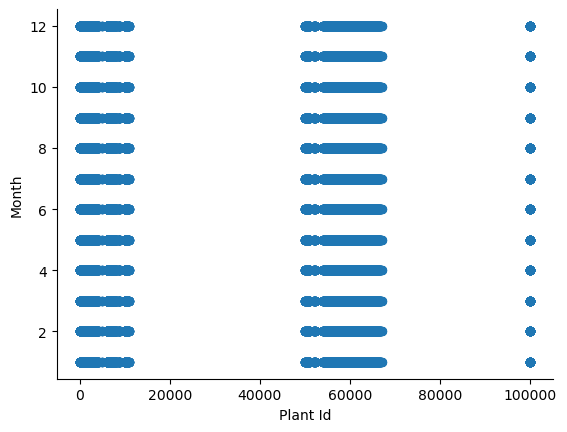

In [4]:
from matplotlib import pyplot as plt
data.plot(kind='scatter', x='Plant Id', y='Month', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

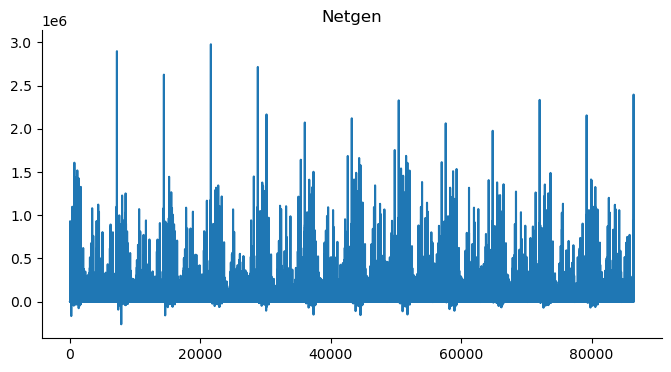

In [5]:
from matplotlib import pyplot as plt
data['Netgen'].plot(kind='line', figsize=(8, 4), title='Netgen')
plt.gca().spines[['top', 'right']].set_visible(False)

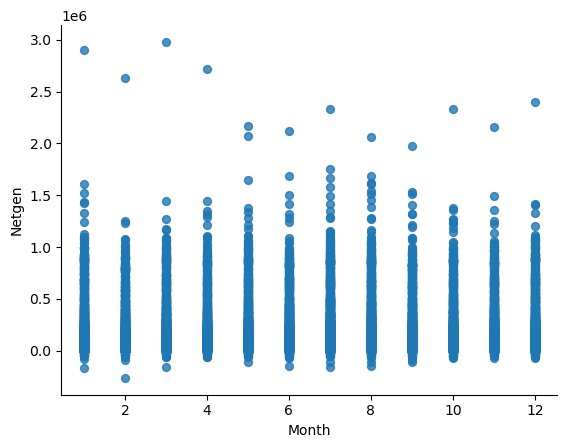

In [6]:
from matplotlib import pyplot as plt
data.plot(kind='scatter', x='Month', y='Netgen', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
# Grouping the data by 'Plant State', 'AER Fuel Type Code', and 'Month' to sum 'Netgen'
grouped_monthly = data.groupby(['Plant State', 'AER Fuel Type Code', 'Month'])['Netgen'].sum().reset_index()
grouped_monthly.rename(columns={'Netgen': 'Net Generation (Megawatthours)'}, inplace=True)
grouped_monthly

,Plant State,AER Fuel Type Code,Month,Net Generation (Megawatthours)
0,AK,COL,1,58756.896
1,AK,COL,2,43801.340
2,AK,COL,3,59387.162
3,AK,COL,4,52466.952
4,AK,COL,5,51859.276
...,...,...,...,...
7831,WY,WOO,8,350.656
7832,WY,WOO,9,775.620
7833,WY,WOO,10,658.904
7834,WY,WOO,11,135.739


In [8]:
# Get unique states, fuel types, and months
states = grouped_monthly['Plant State'].unique()
fuel_types = grouped_monthly['AER Fuel Type Code'].unique()
months = grouped_monthly['Month'].unique()

# Prepare the data matrix
net_gen_data = np.zeros((len(states), len(fuel_types), len(months)))
for i, state in enumerate(states):
    for j, fuel_type in enumerate(fuel_types):
        for k, month in enumerate(months):
            value = grouped_monthly[(grouped_monthly['Plant State'] == state) &
                                    (grouped_monthly['AER Fuel Type Code'] == fuel_type) &
                                    (grouped_monthly['Month'] == month)]['Net Generation (Megawatthours)']
            if not value.empty:
                net_gen_data[i, j, k] = value.values[0]

# Define PyMC model
with pm.Model() as model:
    # Hyperparameters for state-level effects
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    sigma_a = pm.HalfCauchy('sigma_a', beta=1e5)

    # Hyperparameters for fuel type effects within each state
    mu_b = pm.Normal('mu_b', mu=0., sigma=1e5, shape=(len(states), len(fuel_types)))
    sigma_b = pm.HalfCauchy('sigma_b', beta=1e5, shape=(len(states), len(fuel_types)))

    # Hyperparameters for month effects
    mu_m = pm.Normal('mu_m', mu=0., sigma=1e5)
    sigma_m = pm.HalfCauchy('sigma_m', beta=1e5)

    # State effects
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=len(states))

    # Fuel type effects for each state
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=(len(states), len(fuel_types)))

    # Month effects
    m = pm.Normal('m', mu=mu_m, sigma=sigma_m, shape=len(months))

    # Combined mean
    mu = a[:, None, None] + b[:, :, None] + m

    # Observational model for the net generation data
    obs = pm.Normal('obs', mu=mu, sigma=1e6, observed=net_gen_data)

    # Sampling
    trace = pm.sample(1000, tune=500, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, mu_m, sigma_m, a, b, m]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 680 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


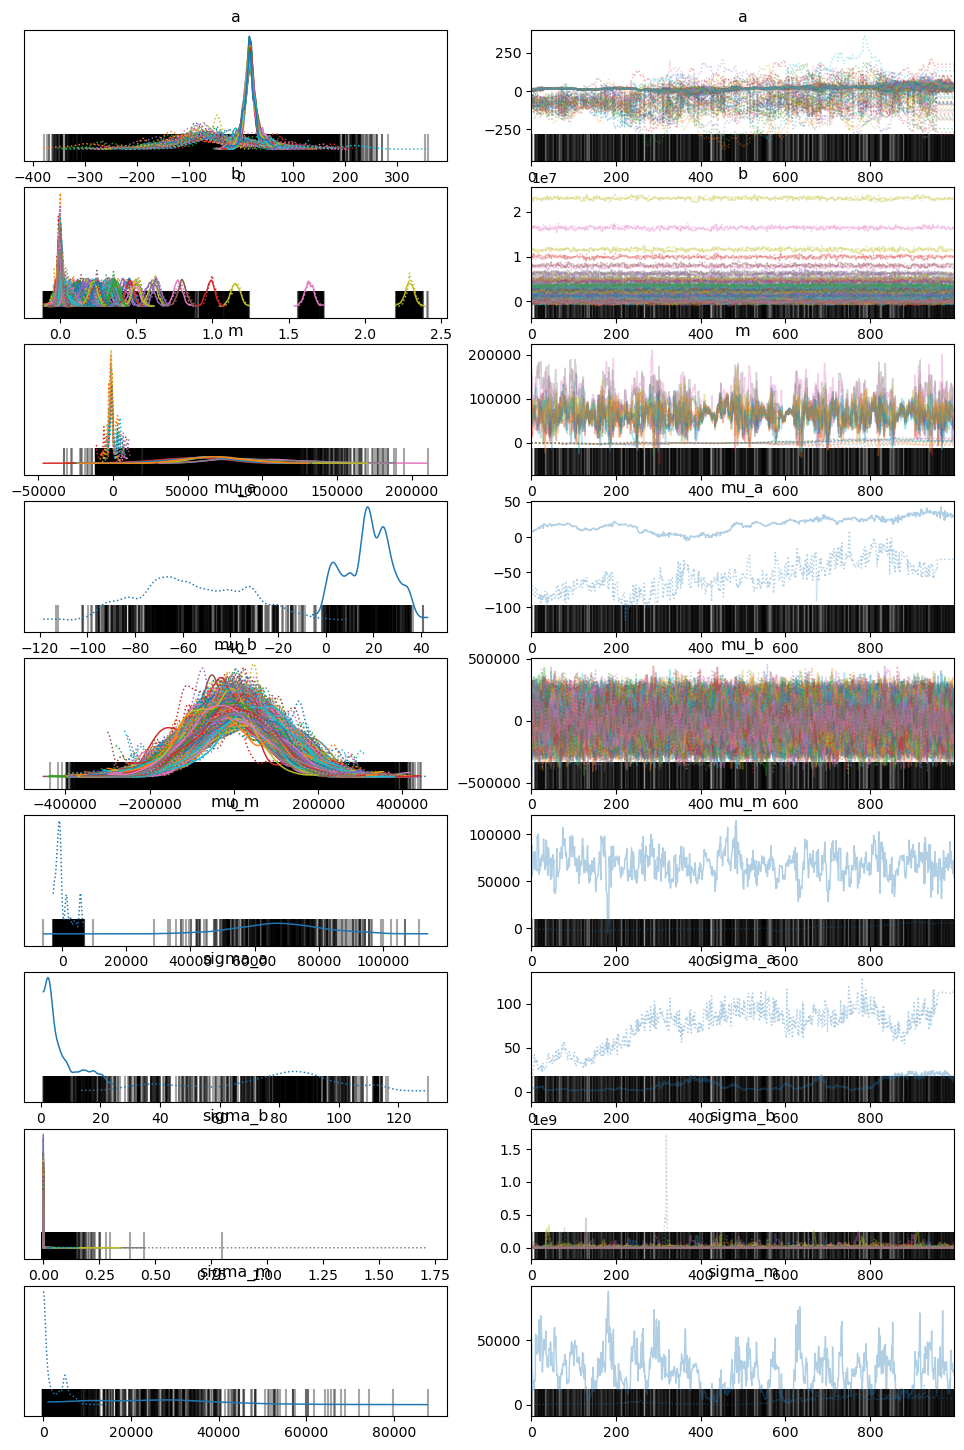

In [10]:
# Plotting results
with model:
    az.plot_trace(trace)
    plt.show()


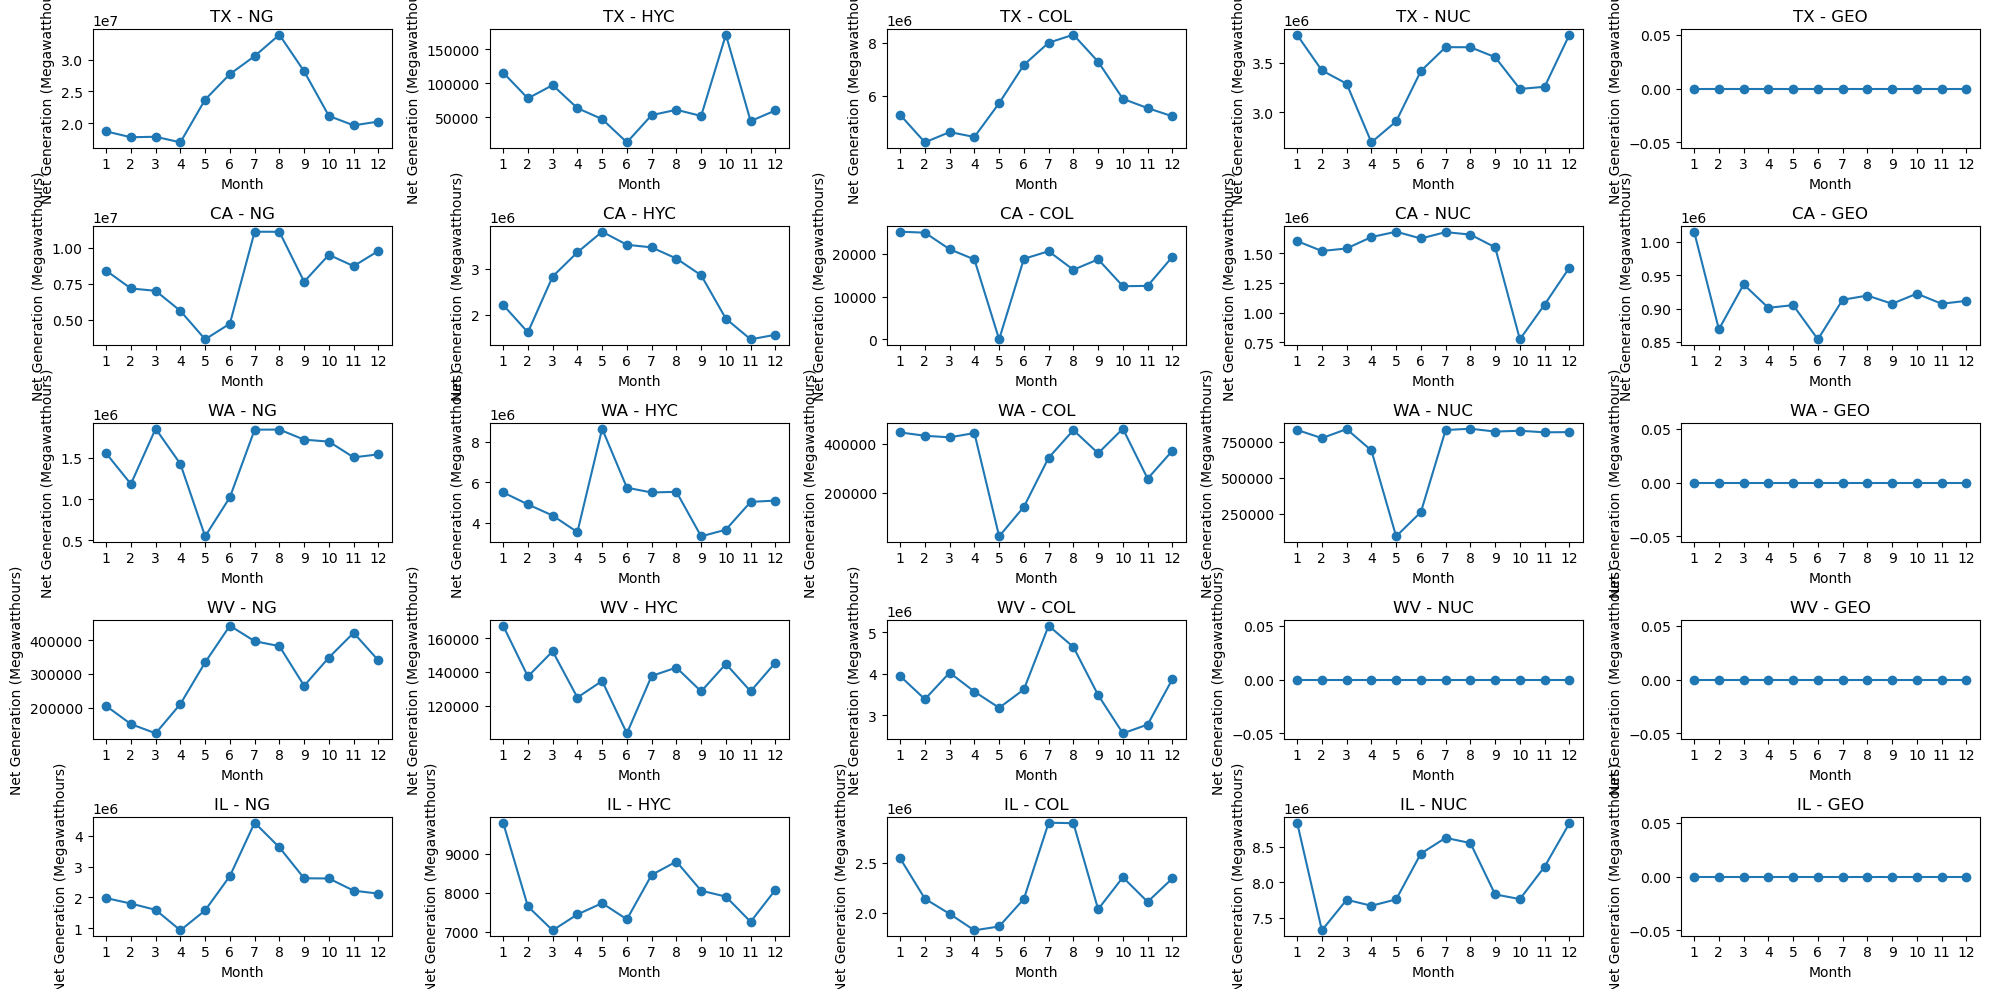

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 定义的州和燃料类型
selected_states = ['TX', 'CA', 'WA', 'WV', 'IL']
selected_fuel_types = ['NG', 'HYC', 'COL', 'NUC', 'GEO']

# 绘制折线图
fig, axs = plt.subplots(len(selected_states), len(selected_fuel_types), figsize=(20, 10), squeeze=False)
for i, state in enumerate(selected_states):
    for j, fuel_type in enumerate(selected_fuel_types):
        state_idx = np.where(states == state)[0][0]
        fuel_type_idx = np.where(fuel_types == fuel_type)[0][0]
        axs[i, j].plot(months, net_gen_data[state_idx, fuel_type_idx, :], marker='o')  # 添加marker以便更好地视觉追踪每个数据点
        axs[i, j].set_title(f"{state} - {fuel_type}")
        axs[i, j].set_xlabel("Month")
        axs[i, j].set_ylabel("Net Generation (Megawatthours)")
        axs[i, j].set_xticks(range(1, 13))
        axs[i, j].set_xticklabels(range(1, 13))

plt.tight_layout()
plt.show()






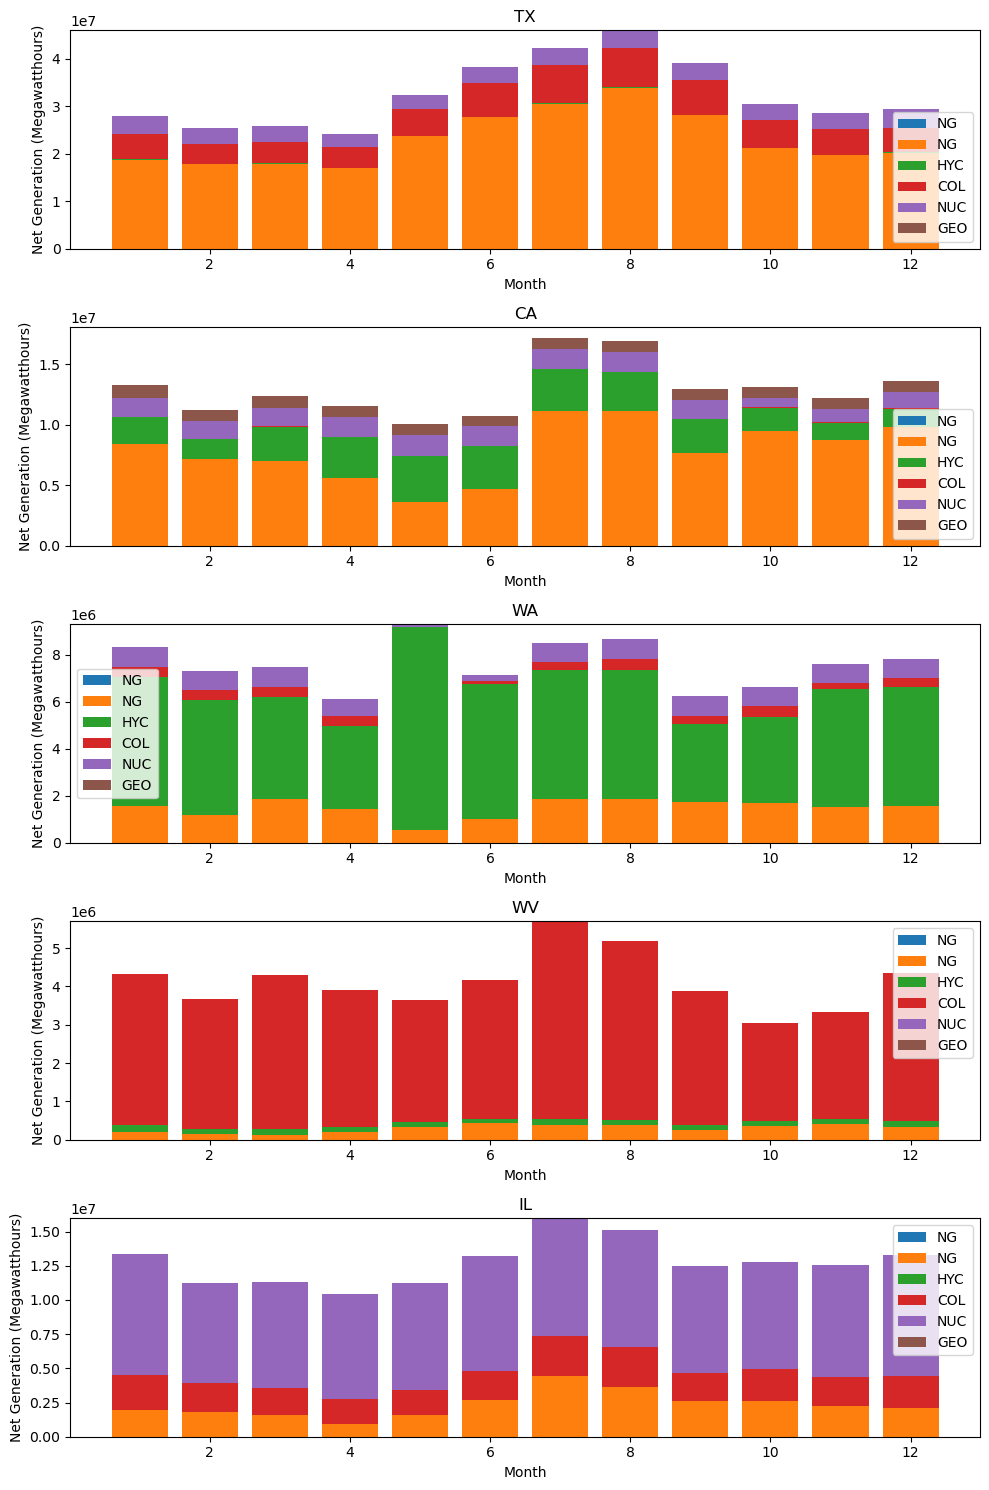

In [12]:
# 绘制选定州的能源组合的堆叠柱状图
fig, axs = plt.subplots(len(selected_states), 1, figsize=(10, 15))
# 确保每个州的每种燃料类型在所有月份都有数据
for i, state in enumerate(selected_states):
    state_idx = np.where(states == state)[0][0]
    axs[i].bar(months, net_gen_data[state_idx, np.where(fuel_types == selected_fuel_types[0])[0][0], :], label=selected_fuel_types[0])
    bottom_stack = np.zeros(len(months))  # 初始化底部堆叠为0
    for j in range(len(selected_fuel_types)):
        fuel_type_idx = np.where(fuel_types == selected_fuel_types[j])[0][0]
        axs[i].bar(months, net_gen_data[state_idx, fuel_type_idx, :], bottom=bottom_stack, label=selected_fuel_types[j])
        bottom_stack += net_gen_data[state_idx, fuel_type_idx, :]  # 更新堆叠底部位置

# 继续其他设置和显示图表

    axs[i].set_title(state)
    axs[i].set_xlabel("Month")
    axs[i].set_ylabel("Net Generation (Megawatthours)")
    axs[i].legend()
plt.tight_layout()
plt.show()


In [13]:
print("Available fuel types:", fuel_types)  # 打印所有可用的燃料类型

Available fuel types: ['COL' 'DFO' 'HYC' 'MLG' 'NG' 'ORW' 'OTH' 'RFO' 'SUN' 'WND' 'WOC' 'WOO'
 'WWW' 'NUC' 'OOG' 'HPS' 'PC' 'GEO']


In [20]:
# Summary statistics for hidden variables and hyperparameters
az.summary(trace, var_names=['a', 'b', 'm', 'mu_a', 'mu_b', 'mu_m', 'sigma_a', 'sigma_b', 'sigma_m'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-23.22,55.46,-137.84,39.60,27.55,21.09,3.95,69.40,1.53
a[1],-44.42,104.75,-311.80,65.50,45.63,34.24,4.44,19.91,1.60
a[2],-5.44,43.71,-93.39,65.99,18.20,13.58,7.43,25.80,1.49
a[3],-11.07,62.22,-138.47,98.36,37.00,29.47,3.36,12.51,1.77
a[4],-41.19,82.38,-199.04,55.88,46.60,36.63,3.52,13.07,1.76
...,...,...,...,...,...,...,...,...,...
"sigma_b[50, 14]",156874.52,236466.16,1319.26,456173.27,17680.02,12522.10,170.12,283.27,1.00
"sigma_b[50, 15]",122592.05,212872.32,555.81,363878.03,10701.49,7572.68,230.82,291.46,1.01
"sigma_b[50, 16]",140539.49,248610.43,193.12,436099.34,15111.69,10697.12,117.46,155.50,1.01
"sigma_b[50, 17]",119610.72,136778.21,263.97,332875.46,7366.87,5213.58,173.86,219.47,1.00


research question2

In [25]:
!pip install pandas openpyxl
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
# df_2023 = pd.read_excel("2023_overall.xlsx", engine='openpyxl', header=5)
# df_2022 = pd.read_excel("2022_overall.xlsx", engine='openpyxl', header=5)
# df_2021 = pd.read_excel("2021_overall.xlsx", engine='openpyxl', header=5)
# df_2020 = pd.read_excel("2020_overall.xlsx", engine='openpyxl', header=5)
# df_2019 = pd.read_excel("2019_overall.xlsx", engine='openpyxl', header=5)
# df_2018 = pd.read_excel("2018_overall.xlsx", engine='openpyxl', header=5)
# df_2017 = pd.read_excel("2017_overall.xlsx", engine='openpyxl', header=5)
# df_2016 = pd.read_excel("2016_overall.xlsx", engine='openpyxl', header=5)
# df_2015 = pd.read_excel("2015_overall.xlsx", engine='openpyxl', header=5)
co2 = pd.read_excel('table1.xlsx', header=4)
edu = pd.read_excel('edu.xlsx')
car = pd.read_excel('veh.xlsx')
gdp = pd.read_csv('gdp.csv')
population = pd.read_csv('population(1).csv',header=1)
price =pd.read_csv('Electricity Prices by State(1).csv')


  Using cached openpyxl-3.1.2-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl.metadata (1.8 kB)
Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)


In [26]:
#ab,msw,obs,wds,www,wws,obl,slw,blq,wdl,lfg,obg,sun,wnd,geo,wat
state_abbreviations = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}
print(1)


1


In [27]:
clean = ["SUN", "WND", "GEO", "WAT", "NUC", "AB", "MSW", "OBS", "WDS", "OBL", "SLW", "BLO", "WDL", "LFG", "OBG", "NUC", "SUN", "WND", "GEO", "WAT"
]


In [28]:
# df_2023_total=df_2023.groupby('Plant State')['Net Generation\n(Megawatthours)'].sum()


In [29]:
# df_2023_clean =df_2023[df_2023['AER\nFuel Type Code'].isin(clean)] 

In [30]:
# df_2023_clean_total = df_2023_clean.groupby('Plant State')['Net Generation\n(Megawatthours)'].sum()
# df_2023_clean_total = df_2023_clean_total.reset_index()

In [31]:
# df_2023_rate = pd.DataFrame({
#     'Year': 2023,
#     'State': df_2023_clean_total['Plant State'],
#     'clean Rate': df_2023_clean_total['Net Generation\n(Megawatthours)']/df_2023_total[1]
# })

In [32]:
import pandas as pd

# Define clean energy types (assuming these do not change year to year)
clean_types = ["SUN", "WND", "GEO", "WAT", "NUC", "ABI", "MSW", "OBS", "WDS", "OBL", "SLW", "BLO", "WDL", "LFG", "OBG"]

# Initialize a dictionary to hold dataframes for each year
df_clean_rates = {}

# Loop through each year, processing as per the steps outlined
for year in range(2016, 2022):
    file_path = f"{year}_overall.xlsx"  # Adjust this if file names are different
    df_year = pd.read_excel(file_path, engine='openpyxl', header=5)
    
    # Filter for clean energy types
    df_year_clean = df_year[df_year['AER\nFuel Type Code'].isin(clean_types)]
    
    # Group by 'Plant State' and sum 'Net Generation (Megawatthours)'
    df_year_clean_total = df_year_clean.groupby('Plant State')['Net Generation\n(Megawatthours)'].sum().reset_index()
    
    # Group the total net generation without filtering to get total per state
    df_year_total = df_year.groupby('Plant State')['Net Generation\n(Megawatthours)'].sum().reset_index()
    
    # Merge clean total with overall total to calculate the rate
    df_merged = pd.merge(df_year_clean_total, df_year_total, on='Plant State', suffixes=('_clean', '_total'))
    
    # Calculate the renewable rate
    df_merged['Clean Rate'] = df_merged['Net Generation\n(Megawatthours)_clean'] / df_merged['Net Generation\n(Megawatthours)_total']
    df_merged['Year'] = year
    # Add to dictionary
    df_clean_rates[year] = df_merged[['Year','Plant State', 'Clean Rate']]

# Optionally combine all yearly data into a single DataFrame for analysis
df_all_years = pd.concat(df_clean_rates, ignore_index=True)
df_all_years.rename(columns={'Plant State': 'State'}, inplace=True)

df_all_years

,Year,State,Clean Rate
0,2016,AK,0.026725
1,2016,AL,0.280459
2,2016,AR,0.222469
3,2016,AZ,0.337291
4,2016,CA,0.318235
...,...,...,...
298,2021,VT,0.242677
299,2021,WA,0.161172
300,2021,WI,0.185612
301,2021,WV,0.024669


In [33]:
# import pandas as pd
# df_all_years.sort_values(by=['State', 'Year'], inplace=True)
# df_all_years['Rate Change'] = df_all_years.groupby('State')['Clean Rate'].diff() * 100
# significant_growth = df_all_years[(df_all_years['Rate Change'] > 3.26) & (df_all_years['Year'].between(2016, 2021))]

# print(significant_growth)



In [34]:
import pandas as pd
df_all_years.sort_values(by=['State', 'Year'], inplace=True)
df_all_years['Rate Change'] = df_all_years.groupby('State')['Clean Rate'].diff() * 100
df_all_years['Treatment'] = ((df_all_years['Rate Change'] > 3.26) & (df_all_years['Year'].between(2017, 2021))).astype(int)
df_all_years = df_all_years.dropna()
df_all_years

# print(df_all_years[['Year', 'Plant State', 'Clean Rate', 'Rate Change', 'Treatment']])


,Year,State,Clean Rate,Rate Change,Treatment
50,2017,AK,0.021807,-0.491806,0
100,2018,AK,0.024813,0.300638,0
150,2019,AK,0.023488,-0.132506,0
201,2020,AK,0.020479,-0.300919,0
252,2021,AK,0.020045,-0.043382,0
...,...,...,...,...,...
99,2017,WY,0.092437,-0.164092,0
149,2018,WY,0.088002,-0.443408,0
200,2019,WY,0.103046,1.504387,0
251,2020,WY,0.135155,3.210874,0


In [35]:
# co2

df_dropped = co2.iloc[:, :-4]
melted_data_co2 = df_dropped.melt(id_vars=["State"], var_name="Year", value_name="co2 Value")
melted_data_co2['Year'] = melted_data_co2['Year'].astype(int)
df_filtered_co2 = melted_data_co2.loc[melted_data_co2['Year'] >= 2016]
df_filtered_co2 = df_filtered_co2.dropna()
df_filtered_co2.drop(df_filtered_co2.index[-1])

df_filtered_co2['State'] = df_filtered_co2['State'].map(state_abbreviations)

merged_co2 = pd.merge(df_all_years, df_filtered_co2, on=['State', 'Year'],how='inner')
merged_co2 = merged_co2.dropna()


In [36]:
# gdp
melted_data_gdp = gdp.melt(id_vars=["State"], var_name="Year", value_name="gdp")
melted_data_gdp['Year'] = melted_data_gdp['Year'].astype(int)
merged_data_gdp_co2 = pd.merge(merged_co2, melted_data_gdp, on=['State', 'Year'],how='inner')
df= merged_data_gdp_co2.dropna()

In [37]:
df_long = pd.melt(population, id_vars=['state'], var_name='year', value_name='population')
df_long= df_long.rename(columns={    
    'state':'State',
    'year': 'Year',})
df_long = df_long.dropna()
df_long['Year'] = df_long['Year'].str.replace(',', '').astype(int)
df_long['population'] = df_long['population'].str.replace(',', '').astype(int)
merged_data_population = pd.merge(df_long, df, on=['State', 'Year'],how='inner')

In [38]:
edu.head()

,NAME,2017,2018,2019,2020,2021
0,Geographic Area Name,Percent bachelor's degree or higher,Percent bachelor's degree or higher,Percent bachelor's degree or higher,Percent bachelor's degree or higher,Percent bachelor's degree or higher
1,United States,32,32.6,33.1,NaN,35
2,Alabama,25.5,25.5,26.3,NaN,27.4
3,Alaska,28.8,30.2,30.2,NaN,32.8
4,Arizona,29.4,29.7,30.2,NaN,32.4


In [39]:
melted_data_edu = edu.melt(id_vars=["NAME"], var_name="Year", value_name="edu")
melted_data_edu= melted_data_edu.rename(columns={    
    'NAME':'State'})
melted_data_edu['State'] = melted_data_edu['State'].map(state_abbreviations)
melted_data_edu['Year'] = melted_data_edu['Year'].astype(int)
merged_data_gdp_co2_edu = pd.merge(merged_data_population, melted_data_edu, on=['State', 'Year'],how='inner')

df_3= merged_data_gdp_co2_edu.dropna()
df_3['edu'] = df_3['edu'].astype(int)
df_3['edu']

/tmp/ipykernel_910/2721122039.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['edu'] = df_3['edu'].astype(int)


0      28
1      25
2      23
3      29
4      33
       ..
245    44
246    39
247    32
248    24
249    29
Name: edu, Length: 200, dtype: int64

In [40]:
# car
car['Year'] = car['Year'].astype(int)
car['State'] = car['State'].str.replace(' ', '')
car['State'] = car['State'].map(lambda x: state_abbreviations.get(x, x))

df_4 = pd.merge(df_3, car, on=['State', 'Year'],how='inner')
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   State        160 non-null    object 
 1   Year         160 non-null    int64  
 2   population   160 non-null    int64  
 3   Clean Rate   160 non-null    float64
 4   Rate Change  160 non-null    float64
 5   Treatment    160 non-null    int64  
 6   co2 Value    160 non-null    float64
 7   gdp          160 non-null    float64
 8   edu          160 non-null    int64  
 9   total        160 non-null    float64
dtypes: float64(5), int64(4), object(1)
memory usage: 12.6+ KB


In [41]:
# price

price= price.rename(columns={    
    'STATE':'State'})
price['State'] = price['State'].map(state_abbreviations)
price_melt = price.melt(id_vars=["State"], var_name="Year", value_name="ele_price")
price_melt['Year'] = price_melt['Year'].astype(int)
df_5 = pd.merge(df_4, price_melt, on=['State', 'Year'],how='inner')

In [42]:
df_5

,State,Year,population,Clean Rate,Rate Change,Treatment,co2 Value,gdp,edu,total,ele_price
0,AK,2017,4877989,0.021807,-0.491806,0,33.731095,214606.3,28,1.734870e+05,22.30
1,AL,2017,740983,0.306026,2.556702,0,108.594556,53301.5,25,2.065463e+06,12.53
2,AR,2017,7048088,0.209327,-1.314225,0,64.176360,332001.8,23,9.267890e+05,10.67
3,AZ,2017,3003855,0.357595,2.030455,0,90.480865,122466.7,29,2.391624e+06,12.74
4,CA,2017,39337785,0.323248,0.501326,0,356.532043,2728743.1,33,1.486097e+07,18.85
...,...,...,...,...,...,...,...,...,...,...,...
155,VA,2021,647093,0.341134,3.536753,1,97.953403,37103.8,41,2.978391e+06,9.14
156,VT,2021,8657348,0.242677,-1.999956,0,5.572401,604957.6,44,1.800255e+05,16.34
157,WA,2021,7741433,0.161172,-0.020734,0,73.801077,677489.5,39,2.977074e+06,8.75
158,WI,2021,1785249,0.185612,-0.361517,0,92.461744,85434.2,32,1.825450e+06,11.01


In [43]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = df_5[['population', 'gdp', 'edu', 'total', 'ele_price']]  
X_scaled = scaler.fit_transform(X)

log_reg = LogisticRegression()
log_reg.fit(X_scaled, df_5['Treatment'])


df_5['propensity_score'] = log_reg.predict_proba(X_scaled)[:, 1]


In [44]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=1)


treated = df_5[df_5['Treatment'] == 1]
control = df_5[df_5['Treatment'] == 0]

nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

matched_pairs = treated.reset_index().join(control.iloc[indices.flatten()].reset_index(), lsuffix='_treated', rsuffix='_control')


In [45]:

ate = (matched_pairs['co2 Value_treated'] - matched_pairs['co2 Value_control']).mean()
print(f"Average Treatment Effect on CO2 Value: {ate}")


Average Treatment Effect on CO2 Value: -30.548609528924704


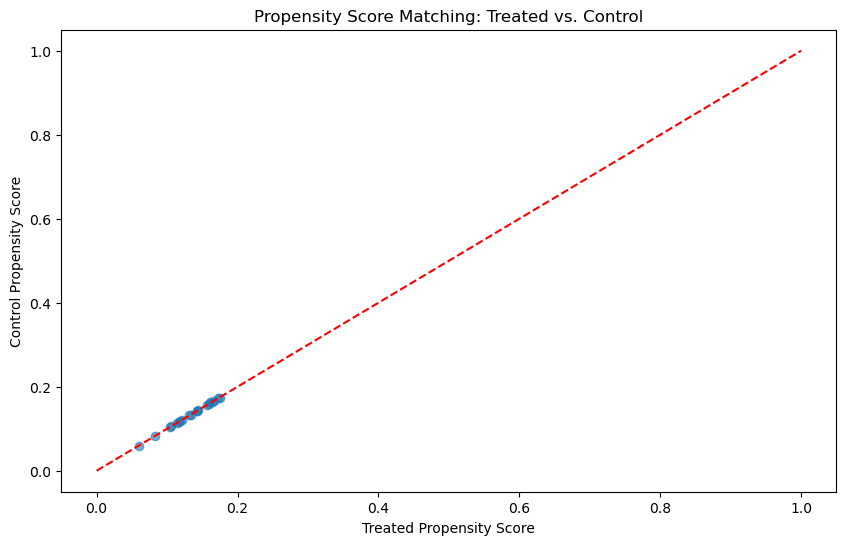

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(matched_pairs['propensity_score_treated'], matched_pairs['propensity_score_control'], alpha=0.6)
plt.title('Propensity Score Matching: Treated vs. Control')
plt.xlabel('Treated Propensity Score')
plt.ylabel('Control Propensity Score')
plt.plot([0, 1], [0, 1], 'r--') 
plt.show()


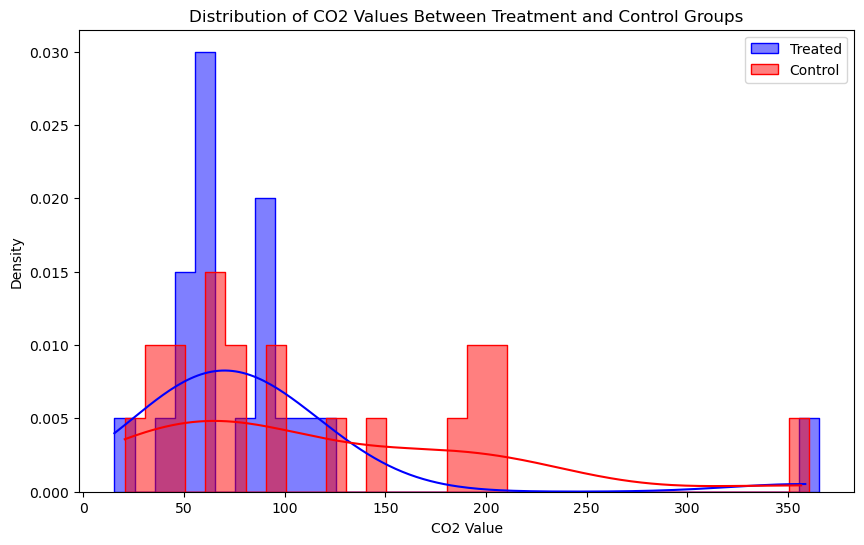

In [47]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(data=matched_pairs, x='co2 Value_treated', color='blue', label='Treated', kde=True, element='step', stat="density", common_norm=False, binwidth=10)
sns.histplot(data=matched_pairs, x='co2 Value_control', color='red', label='Control', kde=True, element='step', stat="density", common_norm=False, binwidth=10)
plt.title('Distribution of CO2 Values Between Treatment and Control Groups')
plt.xlabel('CO2 Value')
plt.ylabel('Density')
plt.legend()
plt.show()


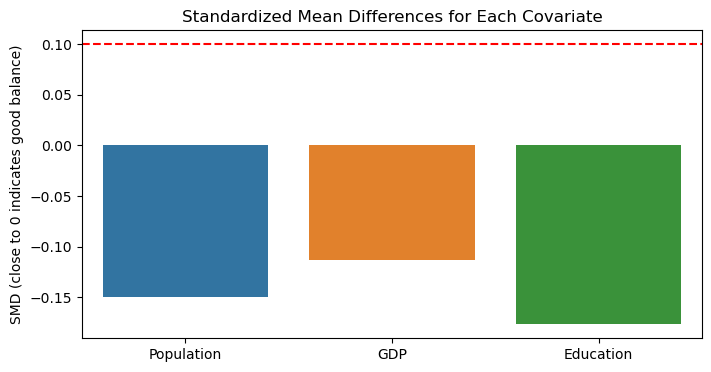

-0.17665548052655333

In [48]:
import numpy as np

def compute_smd(df, var, group):
    means = df.groupby(group)[var].mean()
    stds = df.groupby(group)[var].std()
    return (means[1] - means[0]) / np.sqrt((stds[1]**2 + stds[0]**2) / 2)

smd_population = compute_smd(df_5, 'population', 'Treatment')
smd_gdp = compute_smd(df_5, 'gdp', 'Treatment')
smd_edu = compute_smd(df_5, 'edu', 'Treatment')

smd_values = [smd_population, smd_gdp, smd_edu]
variables = ['Population', 'GDP', 'Education']
plt.figure(figsize=(8, 4))
sns.barplot(x=variables, y=smd_values)
plt.title('Standardized Mean Differences for Each Covariate')
plt.ylabel('SMD (close to 0 indicates good balance)')
plt.axhline(0.1, color='red', linestyle='--')  
plt.show()
smd_edu

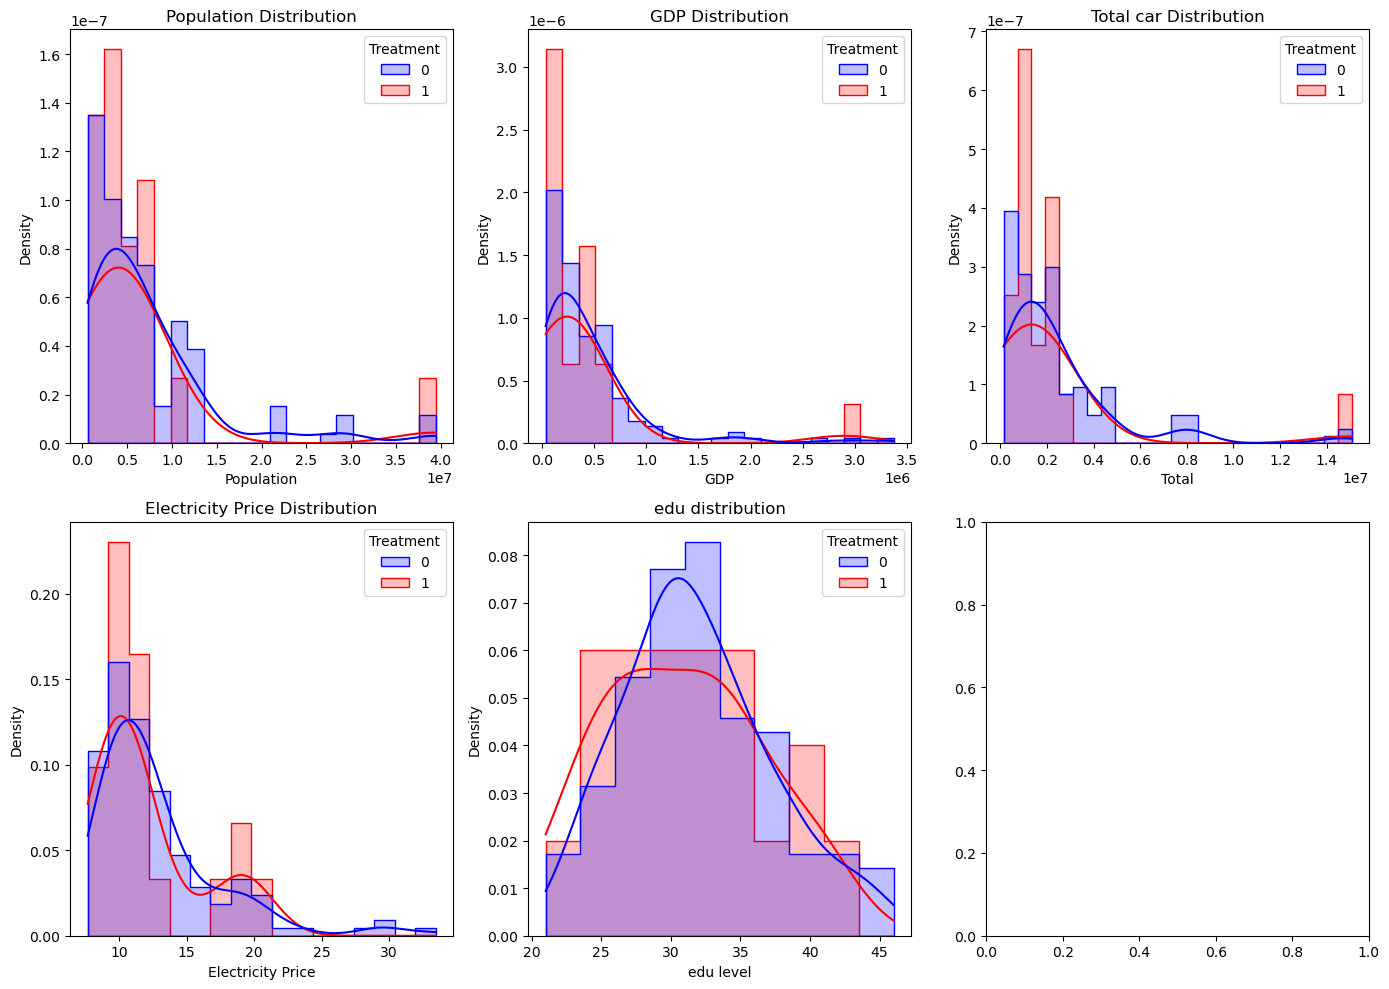

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

variables = ['population', 'gdp', 'total', 'ele_price','edu']
titles = ['Population Distribution', 'GDP Distribution', 'Total car Distribution', 'Electricity Price Distribution','edu distribution']
x_labels = ['Population', 'GDP', 'Total', 'Electricity Price','edu level']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 10))
axes = axes.flatten() 

for i, var in enumerate(variables):
    ax = sns.histplot(data=df_5, x=var, hue='Treatment', element='step', stat="density", kde=True, common_norm=False, palette=['blue', 'red'], ax=axes[i])
    ax.set_title('legend=True')
    ax.set_title(titles[i]) 
    ax.set_xlabel(x_labels[i])  
    ax.set_ylabel('Density')  
    handles, labels = ax.get_legend_handles_labels()
    new_labels = ['Treated', 'Control']
    

plt.tight_layout() 
plt.show() 


In [50]:
# variables = ['population', 'gdp', 'total', 'ele_price', 'edu']
# titles = ['Population Distribution', 'GDP Distribution', 'Total Distribution', 'Electricity Price Distribution', 'Education Distribution']
# x_labels = ['Population', 'GDP', 'Total', 'Electricity Price', 'Education Level']

# fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 15))
# axes = axes.flatten() 

# for i, var in enumerate(variables):
#     ax = sns.histplot(data=df_5, x=var, hue='Treatment', element='step', stat="density", kde=True, common_norm=False, palette=['blue', 'red'], ax=axes[i])
#     ax.set_title('legend=True')
#     ax.set_title(titles[i])
#     ax.set_xlabel(x_labels[i])
#     ax.set_ylabel('Density')
#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles, ['Treated', 'Control'], title="Treatment")

# # Hide the last empty subplot
# axes[-1].axis('off')

# plt.tight_layout() 
# plt.show()

In [51]:
df.head()

,Year,State,Clean Rate,Rate Change,Treatment,co2 Value,gdp
0,2017,AK,0.021807,-0.491806,0,33.731095,214606.3
1,2018,AK,0.024813,0.300638,0,34.515445,223859.3
2,2019,AK,0.023488,-0.132506,0,34.276830,231561.9
3,2020,AK,0.020479,-0.300919,0,35.977743,230892.1
4,2021,AK,0.020045,-0.043382,0,38.872526,254109.7


In [52]:
df= df_5.copy()
treated = df[df['Treatment'] == 1]
control = df[df['Treatment'] == 0]

nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])


matched_indices = control.iloc[indices.flatten()].index

matched_control = df.loc[matched_indices]
matched_treated = treated.reset_index(drop=True) 


matched_df = pd.concat([matched_treated, matched_control])

In [53]:

mean_treated = matched_treated['co2 Value'].mean()
mean_control = matched_control['co2 Value'].mean()

treatment_effect = mean_treated - mean_control
print("Estimated Treatment Effect (Difference in Means):", treatment_effect)


Estimated Treatment Effect (Difference in Means): -30.548609528924686
